In [4]:
from __future__ import print_function, division
import pydicom
import torch
import os
import sys
import pandas as pd
import numpy as np
import pydicom as DCM
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image, ImageOps, ImageEnhance
from sklearn.preprocessing import LabelEncoder
from skimage import img_as_float
import torchvision
import torch
from sklearn.feature_extraction.image import extract_patches_2d
import PIL
from skimage.util import img_as_bool
from utilsFn import *
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
plt.ion()

In [5]:
train_df =  pd.read_csv('train.csv')
print(train_df['pathology'].value_counts())
print(train_df['pathology'].count())

MALIGNANT    1165
BENIGN       1056
Name: pathology, dtype: int64
2221


In [6]:
test_df =pd.read_csv('test.csv')
print(test_df['pathology'].value_counts())

BENIGN       311
MALIGNANT    274
Name: pathology, dtype: int64


In [7]:
print(train_df['pathology'][11]=='BENIGN')
print(train_df['pathology'][11]=='MALIGNANT')


True
False


In [8]:
label=np.zeros(train_df.pathology.nunique())
label_index =  train_df.pathology_class[27]
label_index

0

In [9]:
label[label_index]=1

In [10]:
label

array([1., 0.])

In [11]:

class FullTrainingDataset(Dataset):
    def __init__(self, full_ds, offset, length):
        self.full_ds = full_ds
        self.offset = offset
        self.length = length
        # super(FullTrainingDataset, self).init()

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        return self.full_ds[i+self.offset]


def trainValSplit(dataset, val_share):
    val_offset = int(len(dataset)*(1-val_share))
    
    return FullTrainingDataset(dataset, 0, val_offset), FullTrainingDataset(dataset, val_offset, len(dataset)-val_offset)


In [12]:
class MammographyDataset(Dataset):
    """Creating CBIS-DDSM pytorch dataset."""

    def __init__(self, csv_file, root_dir,img_size):
        """
        Args:
            csv_file (string): Path to the csv file containing labels.
            root_dir (string): path to CuratedDDSM directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #Image size
        self.img_size = img_size
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.frame = pd.read_csv(csv_file)
        # Image Columns
        self.image_arr = np.asarray(self.frame['image file path'])
        # Labels
        self.label_arr = np.asarray(self.frame['pathology_class'])
        # Calculate Len
        self.data_len = len(self.frame.index)
        # Location of Curated DDSM
        self.root_dir = root_dir
        # Transformations to convert image into 512*512
        self.transformations =  transforms.Compose([transforms.Grayscale(1),
                               transforms.Resize(img_size,interpolation=Image.LANCZOS),
                               transforms.CenterCrop(img_size)])

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        # Open image
        #img_as_img = Image.open(single_image_name)
        image_path = os.path.join(self.root_dir,self.image_arr[index])
        image_dcm= DCM.read_file(image_path)
        
        image_2d = image_dcm.pixel_array.astype(float)
        image_2d_scaled = (np.maximum(image_2d,0)/ image_2d.max()) * 255.0
        image_2d_scaled = np.uint8(image_2d_scaled)
        #Transform image to 512 * 512 
        img = Image.fromarray(image_2d_scaled)
        img_as_img = self.transformations(img)
        # Transform image to tensor
        img_as_tensor = self.to_tensor(img_as_img)

        # Get label(class) of the image based on the cropped pandas column
        image_label = self.label_arr[index]

        return (img_as_tensor, image_label)

In [13]:
classes=train_df['pathology']
print(classes.value_counts())
classes

MALIGNANT    1165
BENIGN       1056
Name: pathology, dtype: int64


0       MALIGNANT
1       MALIGNANT
2          BENIGN
3          BENIGN
4          BENIGN
5       MALIGNANT
6       MALIGNANT
7       MALIGNANT
8          BENIGN
9          BENIGN
10         BENIGN
11         BENIGN
12         BENIGN
13         BENIGN
14      MALIGNANT
15      MALIGNANT
16         BENIGN
17         BENIGN
18         BENIGN
19         BENIGN
20      MALIGNANT
21      MALIGNANT
22      MALIGNANT
23      MALIGNANT
24         BENIGN
25         BENIGN
26         BENIGN
27         BENIGN
28         BENIGN
29         BENIGN
          ...    
2191    MALIGNANT
2192    MALIGNANT
2193    MALIGNANT
2194    MALIGNANT
2195    MALIGNANT
2196    MALIGNANT
2197    MALIGNANT
2198    MALIGNANT
2199       BENIGN
2200       BENIGN
2201    MALIGNANT
2202    MALIGNANT
2203    MALIGNANT
2204    MALIGNANT
2205    MALIGNANT
2206    MALIGNANT
2207    MALIGNANT
2208    MALIGNANT
2209    MALIGNANT
2210    MALIGNANT
2211    MALIGNANT
2212    MALIGNANT
2213       BENIGN
2214       BENIGN
2215    MA

In [14]:
import progressbar as pb

In [15]:
''' Making three classes from mammographic images using ROI'''

############ Generating patches from mammographic images training a patch classifier #############

def isbkg(patch):
    numel = patch.shape[0] * patch.shape[1]
    numzeros  =  np.count_nonzero(patch==0)
    if((numzeros/numel)>0.8):
        return True
    return False

train_file = 'train.csv'

####### No need to see this ##############
test_file = 'test.csv'

train_df = pd.read_csv(train_file)

########## Initiliaze Progress Bar ###########

widgets = ['Progress for making dataset: ', pb.Percentage(), ' ',pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]

timer = pb.ProgressBar(widgets=widgets, maxval=len(train_df)+1).start()


############ making patches and saving to folder ###################

for idx in range(len(train_df)):
    timer.update(idx)
    filename =  train_df['patient_id'][idx]+train_df['image view'][idx]
    imgdcm = train_df['image file path'][idx]
    maskdcm = train_df['ROI mask file path'][idx]
    img =  DCM.read_file(imgdcm).pixel_array.astype(float)
    mask = DCM.read_file(maskdcm).pixel_array.astype(float)
    img = (np.maximum(img,0)/ img.max()) * 255.0
    img = np.uint8(img)
    mask = (np.maximum(mask,0)/mask.max())
    classes = train_df['pathology'][idx]
    patches = extract_patches_2d(img, (512,512),max_patches=50, random_state=1)
    maskpatches = extract_patches_2d(mask,(512,512),max_patches=50,random_state=1)

    i=0
    for eachmask,eachpatch in zip(maskpatches,patches):
        i+=1
        pil = PIL.Image.fromarray(eachpatch)
        if(classes=='MALIGNANT'):
#             print(eachpatch)
#             print(eachmask)
#             print(isbkg(eachpatch))
#             plt.imshow(pil)
            
#             assert False,'qwerty'
            if(img_as_bool(eachmask).any()):
                pil.save(openfile('./images/malignant/{}_{}.png'.format(filename,i)))
            elif(isbkg(eachpatch)):
                pil.save(openfile('./images/bkg/{}_{}.png'.format(filename,i)))
            else:
                pil.save(openfile('./images/othmalignant/{}_{}.png'.format(filename,i)))
            
            
        elif(classes=='BENIGN'):
            if(img_as_bool(eachmask).any()):
                pil.save(openfile('./images/benign/{}_{}.png'.format(filename,i)))
            elif(isbkg(eachpatch)):
                pil.save(openfile('./images/bkg/{}_{}.png'.format(filename,i)))
            else:
                pil.save(openfile('./images/othbenign/{}_{}.png'.format(filename,i)))
        else:
            assert False, 'Unknown class found'
timer.finish()

KeyboardInterrupt: 

37
MALIGNANT
P_00057MLO


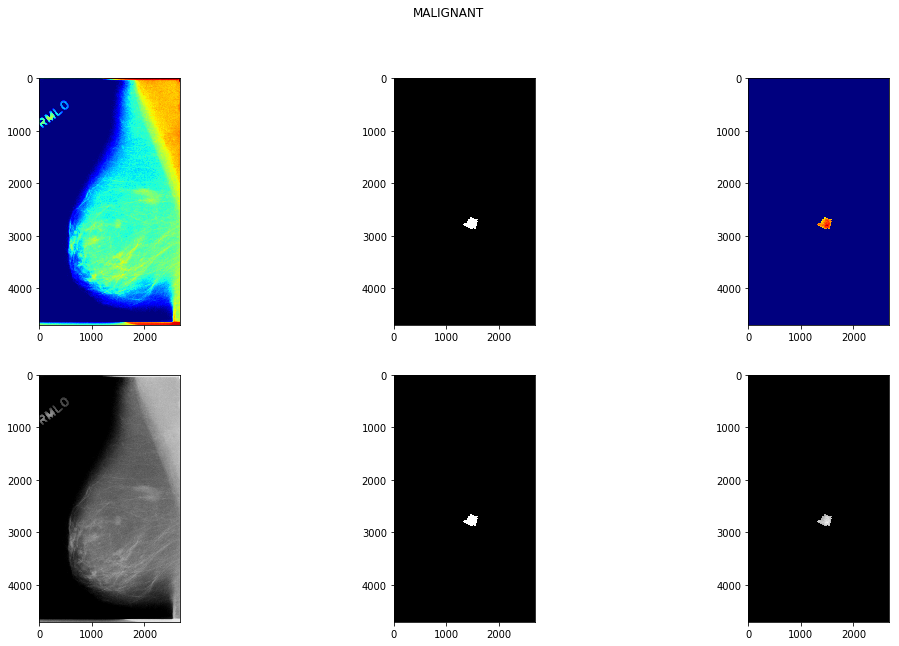

In [244]:
idx=np.random.randint(0,2221)
# idx=24
# idx = 1531
# idx = 2186
# for idx in range(len(train_df)):
#idx = 243 benign
#idx = 27 benign
print(idx)
filename =  train_df['patient_id'][idx]+train_df['image view'][idx]
imgdcm = train_df['image file path'][idx]
maskdcm = train_df['ROI mask file path'][idx]
img =  DCM.read_file(imgdcm).pixel_array.astype(float)
mask = DCM.read_file(maskdcm).pixel_array.astype(float)
img = (np.maximum(img,0)/ img.max()) * 255.0
img = np.uint8(img)
mask = (np.maximum(mask,0)/mask.max())
# print(imgdcm)
# print(maskdcm)
print(train_df['pathology'][idx])
plt.rcParams["figure.figsize"] = [18,10]
f = plt.figure(figsize=(18,10))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3=f.add_subplot(233)
ax.imshow(img,cmap='jet')
ax2.imshow(mask,cmap='gray')
ax3.imshow(img*mask,cmap='jet')
# f = plt.figure(figsize=(15,12))
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6=f.add_subplot(236)
ax4.imshow(img,cmap='gray')
ax5.imshow(mask,cmap='gray')
ax6.imshow(img*mask,cmap='gray')
f.suptitle(train_df['pathology'][idx])
print(filename)
# plt.savefig('./images/'+filename+'.png')








[[140. 139. 137. ... 255. 255. 255.]
 [138. 137. 135. ... 255. 255. 255.]
 [136. 135. 135. ... 255. 255. 255.]
 ...
 [148. 160. 178. ... 255. 255. 255.]
 [150. 161. 199. ... 255. 255. 255.]
 [151. 157. 170. ... 255. 255. 255.]]
[[0.54901961 0.54509804 0.5372549  ... 1.         1.         1.        ]
 [0.54117647 0.5372549  0.52941176 ... 1.         1.         1.        ]
 [0.53333333 0.52941176 0.52941176 ... 1.         1.         1.        ]
 ...
 [0.58039216 0.62745098 0.69803922 ... 1.         1.         1.        ]
 [0.58823529 0.63137255 0.78039216 ... 1.         1.         1.        ]
 [0.59215686 0.61568627 0.66666667 ... 1.         1.         1.        ]]


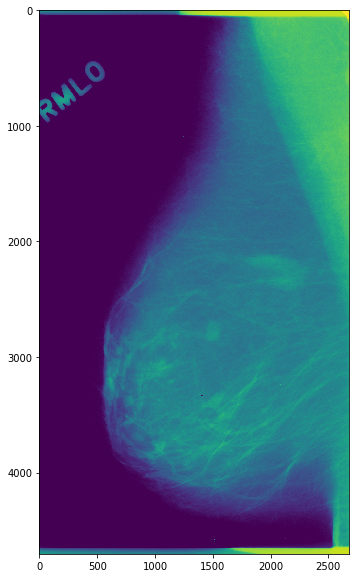

In [246]:
from skimage import img_as_float
print(img.astype(np.float))
plt.imshow(img_as_float(img))
print(img_as_float(img))

In [26]:
# Sliding window 

In [287]:
# import the necessary packages
import imutils

def pyramid(image, scale=1.5, minSize=(30, 30)):
	# yield the original image
	yield image

	# keep looping over the pyramid
	while True:
		# compute the new dimensions of the image and resize it
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)

		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break

		# yield the next image in the pyramid
		yield image

def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [315]:
winSize = 512
stepSize = winSize/4
stepSize = int(stepSize)

patches =  sliding_window(img,stepSize,windowSize=(winSize,winSize))
maskpatches =sliding_window(mask,stepSize,windowSize=(winSize,winSize))

In [316]:
print(type(img.shape[0]),type(img.shape[1]),type(mask.shape[0]),type(mask.shape[1]))
print(type(winSize),type(stepSize))

<class 'int'> <class 'int'> <class 'int'> <class 'int'>
<class 'int'> <class 'int'>


In [317]:
def isbkg(patch):
    numel = patch.shape[0] * patch.shape[1]
    numzeros  =  np.count_nonzero(patch<50)
    if((numzeros/numel)>0.8):
        return True
    return False

In [318]:
isbkg(each[2])

False

In [319]:
# i=0
# for eachmask in patches:
#     i+=1
#     print(eachmask[2].shape)

In [320]:
i=0
for eachmask,eachpatch in zip(maskpatches,patches):
    if(eachmask[2].shape==(512,512)):
        i+=1
        print('{}\t{}'.format(eachmask[2].shape,eachpatch[2].shape))
        print('sdf')
print(i)

(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(512, 512)
sdf
(512, 512)	(

2816 128
(512, 208)


AssertionError: check

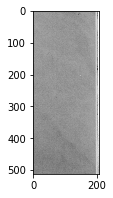

In [216]:
plt.rcParams['figure.figsize']=[3,3]
for each in patcheslide:
    print(each[0],each[1])
    print(each[2].shape)
    plt.imshow(each[2],cmap='gray')
    assert False, 'check'
    
    


In [217]:
print(isbkg(each[2]))
print(each[2])
print(each[2].shape)

False
[[208 210 209 ... 255 255 255]
 [209 209 211 ... 255 255 255]
 [208 211 212 ... 255 255 255]
 ...
 [200 199 200 ... 255 255 255]
 [198 197 198 ... 255 255 255]
 [198 198 199 ... 255 255 255]]
(512, 208)


In [218]:
np.max(mask)

1.0

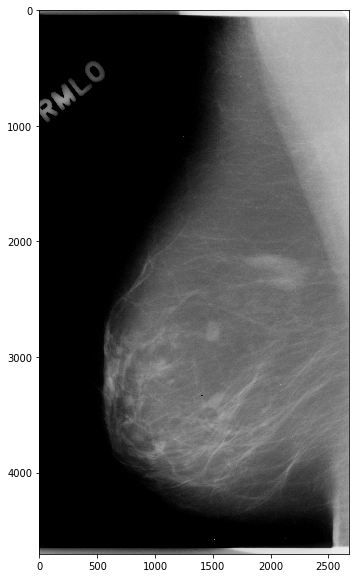

In [321]:
imgPIL = PIL.Image.fromarray(img)
plt.imshow(img,cmap='gray')

In [326]:
img = np.asarray(imgPIL)
print(img)
img = img_as_float(img)
print(img)

[[140 139 137 ... 255 255 255]
 [138 137 135 ... 255 255 255]
 [136 135 135 ... 255 255 255]
 ...
 [148 160 178 ... 255 255 255]
 [150 161 199 ... 255 255 255]
 [151 157 170 ... 255 255 255]]
[[0.54901961 0.54509804 0.5372549  ... 1.         1.         1.        ]
 [0.54117647 0.5372549  0.52941176 ... 1.         1.         1.        ]
 [0.53333333 0.52941176 0.52941176 ... 1.         1.         1.        ]
 ...
 [0.58039216 0.62745098 0.69803922 ... 1.         1.         1.        ]
 [0.58823529 0.63137255 0.78039216 ... 1.         1.         1.        ]
 [0.59215686 0.61568627 0.66666667 ... 1.         1.         1.        ]]


In [ ]:
plt.imshow(imgPIL)
imgPIL = imgPIL.convert("L")
imgPIL.save('../images/'+filename+'.png')
patches=torchvision.transforms.functional.ten_crop(imgPIL, 512, vertical_flip=False)

In [ ]:
idx=np.random.randint(0,2221)
# idx=24
# idx = 1531
idx = 2186
for idx in range(len(train_df)):
    filename =  train_df['patient_id'][idx]+train_df['image view'][idx]
    imgdcm = train_df['image file path'][idx]
    maskdcm = train_df['ROI mask file path'][idx]
    img =  DCM.read_file(imgdcm).pixel_array.astype(float)
    mask = DCM.read_file(maskdcm).pixel_array.astype(float)
    img = (np.maximum(img,0)/ img.max()) * 255.0
    img = np.uint8(img)
    mask = (np.maximum(mask,0)/mask.max())
    # print(imgdcm)
    # print(maskdcm)
#     print(train_df['pathology'][idx])
#     plt.rcParams["figure.figsize"] = [18,10]
#     f = plt.figure(figsize=(18,10))
#     ax = f.add_subplot(231)
#     ax2 = f.add_subplot(232)
#     ax3=f.add_subplot(233)
#     ax.imshow(img,cmap='jet')
#     ax2.imshow(mask,cmap='gray')
#     ax3.imshow(img*mask,cmap='jet')
#     # f = plt.figure(figsize=(15,12))
#     ax4 = f.add_subplot(234)
#     ax5 = f.add_subplot(235)
#     ax6=f.add_subplot(236)
#     ax4.imshow(img,cmap='gray')
#     ax5.imshow(mask,cmap='gray')
#     ax6.imshow(img*mask,cmap='gray')
#     print(filename)
# plt.savefig('./images/'+filename+'.png')

    np.max(mask)


    imgPIL = PIL.Image.fromarray(img)
    # plt.imshow(img,cmap='gray')

    plt.imshow(imgPIL)
    imgPIL = imgPIL.convert("L")
    imgPIL.save('../images/'+filename+'.png')
#     patches=torchvision.transforms.functional.ten_crop(imgPIL, 512, vertical_flip=False)

In [ ]:
from skimage.util.shape import view_as_blocks

In [ ]:
# blocks = view_as_blocks(img,(512,512))

imgPIL = imgPIL.convert("L")
imgPIL.save('../images/'+filename+'.png')

# Convert an image into patches

In [ ]:
plt.imshow(img,cmap='gray')

In [ ]:
img

In [ ]:
imgPIL = PIL.Image.fromarray(img)

In [ ]:
to_tensor = transforms.ToTensor()

In [ ]:
to_tensor(imgPIL).shape

In [ ]:
patches = extract_patches_2d(img, (512,512),max_patches=50, random_state=1)
maskpatches = extract_patches_2d(mask,(512,512),max_patches=50,random_state=1)
labels=[]
for eachmask in maskpatches:
    labels.append(img_as_bool(eachmask).any())
labels = [int(elem) for elem in labels]

In [ ]:
patches = extract_patches_2d(img, (512,512),max_patches=50, random_state=1)
maskpatches = extract_patches_2d(mask,(512,512),max_patches=50,random_state=1)
labels=[]
for eachmask in maskpatches:
    labels.append(img_as_bool(eachmask).any())
labels = [int(elem) for elem in labels]

In [ ]:
len(patches)

In [38]:
def isbkg(patch):
    numel = patch.shape[0] * patch.shape[1]
    numzeros  =  np.count_nonzero(patch==0)
    if((numzeros/numel)>0.8):
        return True
    return False

In [ ]:
dummypatches =  np.random.rand(21,512,512,1)
dummypatches.shape

In [ ]:
from skimage.util import img_as_bool

In [ ]:
pilpatches = PIL.Image.fromarray(patches[0])
pilpatches

In [ ]:
to_tensor = transforms.ToTensor()
patchtensor = to_tensor(pilpatches)
patchtensor.shape

In [ ]:
new=patchtensor.unsqueeze(0)
new.shape

In [ ]:
patches_tensor =  torch.from_numpy(patches)

In [ ]:
patches_tensor.shape
new = patches_tensor.unsqueeze(1)
new[0].shape

In [ ]:
count=0
for eachpatch in patches:
    if count==0:
        f = plt.figure(figsize=(16,8))
        ax = f.add_subplot(171)
        ax2 = f.add_subplot(172)
        ax3=f.add_subplot(173)
        ax4=f.add_subplot(174)
        ax5=f.add_subplot(175)
        ax6=f.add_subplot(176)
        ax7=f.add_subplot(177)
        ax.imshow(eachpatch,cmap='gray')
        count=count+1
        continue
    if count==1:
        count=count+1
        ax2.imshow(eachpatch,cmap='gray')
        continue
    if count==2:
        count=count+1
        ax3.imshow(eachpatch,cmap='gray')
        continue
    if count==3:
        count=count+1
        ax4.imshow(eachpatch,cmap='gray')
        continue
    if count==4:
        count=count+1
        ax5.imshow(eachpatch,cmap='gray')
        continue
    if count==5:
        count=count+1
        ax6.imshow(eachpatch,cmap='gray')
        continue
    if count==6:
        count=count+1
        ax7.imshow(eachpatch,cmap='gray')
        count=0
        continue
print(train_df['pathology'][idx])

In [ ]:
count=0
for eachpatch in maskpatches:
    if count==0:
        f = plt.figure(figsize=(15,12))
        ax = f.add_subplot(131)
        ax2 = f.add_subplot(132)
        ax3=f.add_subplot(133)
        ax.imshow(eachpatch,cmap='gray')
        count=count+1
        continue
    if count==1:
        count=count+1
        ax2.imshow(eachpatch,cmap='gray')
        continue
    if count==2:
        count=count+1
        ax3.imshow(eachpatch,cmap='gray')
        count=0
        continue

In [ ]:
# landmarks_frame = pd.read_csv('faces/face_landmarks.csv')
# n = 65
# # accessing nth row 
# img_name = landmarks_frame.iloc[n, 0]
# landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
# landmarks = landmarks.astype('float').reshape(-1, 2)
# # unknown rows but only two columns x and y

# print('Image name: {}'.format(img_name))
# print('Landmarks shape: {}'.format(landmarks.shape))
# print('First 4 Landmarks: {}'.format(landmarks[:4]))
# plt.imshow(io.imread(os.path.join('faces/',img_name)))

In [ ]:
def createTrainFrame():
    
    train_mass_csv = pd.read_csv("../../CuratedDDSM/Train/mass_case_description_train_set.csv")
    train_calc_csv = pd.read_csv("../../CuratedDDSM/Train/calc_case_description_train_set.csv")
    train_calc_csv = train_calc_csv.rename(columns={'breast density': 'breast_density'})
    train_calc_csv['image file path'] = 'Calc/CBIS-DDSM/'+ train_calc_csv['image file path']
    train_calc_csv['ROI mask file path'] ='CalcROI/CBIS-DDSM/' + train_calc_csv['ROI mask file path']
    train_calc_csv['cropped image file path'] ='CalcROI/CBIS-DDSM/' + train_calc_csv['cropped image file path']
    train_mass_csv['image file path'] = 'Mass/CBIS-DDSM/' + train_mass_csv['image file path']
    train_mass_csv['ROI mask file path'] ='MassROI/CBIS-DDSM/' + train_mass_csv['ROI mask file path']
    train_mass_csv['cropped image file path'] ='MassROI/CBIS-DDSM/'+ train_mass_csv['cropped image file path']
    common_col = list(set(train_calc_csv.columns) & set(train_mass_csv.columns))
    train = pd.concat([train_mass_csv[common_col], train_calc_csv[common_col]], ignore_index=True,sort='False')
    train['image file path'] = 'CuratedDDSM/Train/'+train['image file path'] 
    train['ROI mask file path'] = 'CuratedDDSM/Train/'+train['ROI mask file path']
    train['cropped image file path'] = 'CuratedDDSM/Train/'+train['cropped image file path']
    train['pathology_class'] = LabelEncoder().fit_transform(train_df['pathology'])
    
    return train

def createTestFrame():
    test_mass_csv = pd.read_csv("../CuratedDDSM/Test/mass_case_description_test_set.csv")
    test_calc_csv = pd.read_csv("../CuratedDDSM/Test/calc_case_description_test_set.csv")
    test_calc_csv = test_calc_csv.rename(columns={'breast density': 'breast_density'})
    test_calc_csv['image file path'] = 'Calc/CBIS-DDSM/'+ test_calc_csv['image file path']
    test_calc_csv['ROI mask file path'] ='CalcROI/CBIS-DDSM/' + test_calc_csv['ROI mask file path']
    test_calc_csv['cropped image file path'] ='CalcROI/CBIS-DDSM/' + test_calc_csv['cropped image file path']
    test_mass_csv['image file path'] = 'Mass/CBIS-DDSM/' + test_mass_csv['image file path']
    test_mass_csv['ROI mask file path'] ='MassROI/CBIS-DDSM/' + test_mass_csv['ROI mask file path']
    test_mass_csv['cropped image file path'] ='MassROI/CBIS-DDSM/'+ test_mass_csv['cropped image file path']
    common_col = list(set(test_calc_csv.columns) & set(test_mass_csv.columns))
    test = pd.concat([test_mass_csv[common_col], test_calc_csv[common_col]], ignore_index=True,sort='False')
    test['image file path'] = 'CuratedDDSM/Test/'+test['image file path'] 
    test['ROI mask file path'] = 'CuratedDDSM/Test/'+test['ROI mask file path']
    test['cropped image file path'] = 'CuratedDDSM/Test/'+test['cropped image file path']
    train['pathology_class'] = LabelEncoder().fit_transform(train_df['pathology'])
    
    return test

In [ ]:
train_df['class'] = LabelEncoder().fit_transform(train_df['pathology']) 
train_df[['pathology', 'class']]
    

In [ ]:
train_df = createTrainFrame()
test_df = createTestFrame()
mammogram_dir = '/home/himanshu/CuratedDDSM/'
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')
pd.get_dummies(train_df, columns=['pathology'])
# pytorch handles numeric labels for inbuilt loss functions
train_df

In [ ]:
train_df = createTrainFrame()

In [ ]:

# image_path = os.path.join(homedir,train['image file path'][0])
# image_path

In [ ]:
# train['image file path'][0]

In [ ]:
# train = pd.concat([train_calc_csv[common_col], train_mass_csv[common_col]], ignore_index=True,sort='False')
# train['image file path'] = 'CuratedDDSM/Train/'+train['image file path'] 


In [ ]:
labels = set(train_df['pathology'])
labels

In [ ]:
# a =  DCM.read_file('../CuratedDDSM/Train/Calc/CBIS-DDSM/Calc-Training_P_00005_RIGHT_CC/08-07-2016-DDSM-23157/1-full mammogram images-38548/000000.dcm')

In [ ]:
# index=0
# image = DCM.read_file('../CuratedDDSM/Train/'+train_mass_csv['image file path'][index])
# label = train_mass_csv['pathology'][index]
# print(image.pixel_array.shape)
# image_2d = image.pixel_array.astype(float)
# # plt.imshow(image_2d,cmap='gray')
# image_2d_scaled = (np.maximum(image_2d,0)/ image_2d.max()) * 255.0
# image_2d_scaled = np.uint8(image_2d_scaled)
# # plt.imshow(image_2d_scaled,cmap='gray')
# transformations = \
#             transforms.Compose([transforms.Grayscale(3),
#                                transforms.Resize(512,interpolation=Image.LANCZOS),
#                                transforms.CenterCrop(512)])
# img = Image.fromarray(image_2d_scaled)
# img = transformations(img)
# print(img.getpixel)
# img_np = np.asarray(img)
# plt.imshow(img_np)
# img_np.shape

In [ ]:
class MammographyDataset(Dataset):
    """Creating CBIS-DDSM pytorch dataset."""

    def __init__(self, csv_file, root_dir):
        """
        Args:
            csv_file (string): Path to the csv file containing labels.
            root_dir (string): path to CuratedDDSM directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.frame = pd.read_csv(csv_file)
        # Image Columns
        self.image_arr = np.asarray(self.frame['image file path'])
        # Labels
        self.label_arr = np.asarray(self.frame['pathology'])
        # Calculate Len
        self.data_len = len(self.frame.index)
        # Location of Curated DDSM
        self.root_dir = root_dir
        # Transformations to convert image into 512*512
        self.transformations = \
            transforms.Compose([transforms.Grayscale(1),
                               transforms.Resize(512,interpolation=Image.LANCZOS),
                               transforms.CenterCrop(512)])

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        # Open image
        #img_as_img = Image.open(single_image_name)
        image_path = os.path.join(self.root_dir,self.image_arr[index])
        image_dcm= DCM.read_file(image_path)
        
        image_2d = image_dcm.pixel_array.astype(float)
        image_2d_scaled = (np.maximum(image_2d,0)/ image_2d.max()) * 255.0
        image_2d_scaled = np.uint8(image_2d_scaled)
        #Transform image to 512 * 512 
        img = Image.fromarray(image_2d_scaled)
        img_as_img = self.transformations(img)
        # Transform image to tensor
        img_as_tensor = self.to_tensor(img_as_img)

        # Get label(class) of the image based on the cropped pandas column
        image_label = self.label_arr[index]

        return (img_as_tensor, image_label)

In [ ]:
# import numpy as np
# import png
# import pydicom

# ds = pydicom.dcmread(path)

# shape = ds.pixel_array.shape

# # Convert to float to avoid overflow or underflow losses.
# image_2d = ds.pixel_array.astype(float)

# # Rescaling grey scale between 0-255
# image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0

# # Convert to uint
# image_2d_scaled = np.uint8(image_2d_scaled)

# # Write the PNG file
# with open(destination, 'wb') as png_file:
#     w = png.Writer(shape[1], shape[0], greyscale=True)
#     w.write(png_file, image_2d_scaled)